In [1]:
# Install Kaggle API if needed
!pip install -q kaggle

# Import libraries
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [3]:
# Upload your Kaggle API key file
from google.colab import files
uploaded = files.upload()  # Upload kaggle.json manually

# Fix the filename if needed
import shutil

# Rename the uploaded file to kaggle.json (this works regardless of the uploaded name)
for fname in uploaded.keys():
    shutil.move(fname, "kaggle.json")

# Create Kaggle directory and move the key there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the dataset
!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d alzheimer_dataset

Saving kaggle (1).json to kaggle (1) (1).json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): apache-2.0


In [4]:
# Set image size and batch size
img_size = 128
batch_size = 32

# Define paths to training and test directories
train_dir = "alzheimer_dataset/Combined Dataset/train"
test_dir = "alzheimer_dataset/Combined Dataset/test"

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_size, img_size),
    color_mode='grayscale',
    label_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_size, img_size),
    color_mode='grayscale',
    label_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

# Get class names
class_names = train_ds.class_names
print("Class names:", class_names)


Found 10240 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.
Class names: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


In [5]:
# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,705,540 (14.14 MB)

 Trainable params: 3,705,540 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_ds, validation_data=test_ds, epochs=5)


Epoch 1/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 130s 403ms/step - accuracy: 0.4971 - loss: 1.0842 - val_accuracy: 0.6740 - val_loss: 0.7355
Epoch 2/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 129s 402ms/step - accuracy: 0.7421 - loss: 0.5576 - val_accuracy: 0.7404 - val_loss: 0.5956
Epoch 3/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 143s 404ms/step - accuracy: 0.7867 - loss: 0.4498 - val_accuracy: 0.8374 - val_loss: 0.4407
Epoch 4/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 137s 429ms/step - accuracy: 0.8248 - loss: 0.3693 - val_accuracy: 0.8921 - val_loss: 0.3153
Epoch 5/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 136s 411ms/step - accuracy: 0.8510 - loss: 0.3092 - val_accuracy: 0.9218 - val_loss: 0.2255


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step
                      precision    recall  f1-score   support

     Mild Impairment       0.94      0.95      0.94       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.93      0.93      0.93       640
Very Mild Impairment       0.90      0.90      0.90       448

            accuracy                           0.92      1279
           macro avg       0.94      0.94      0.94      1279
        weighted avg       0.92      0.92      0.92      1279



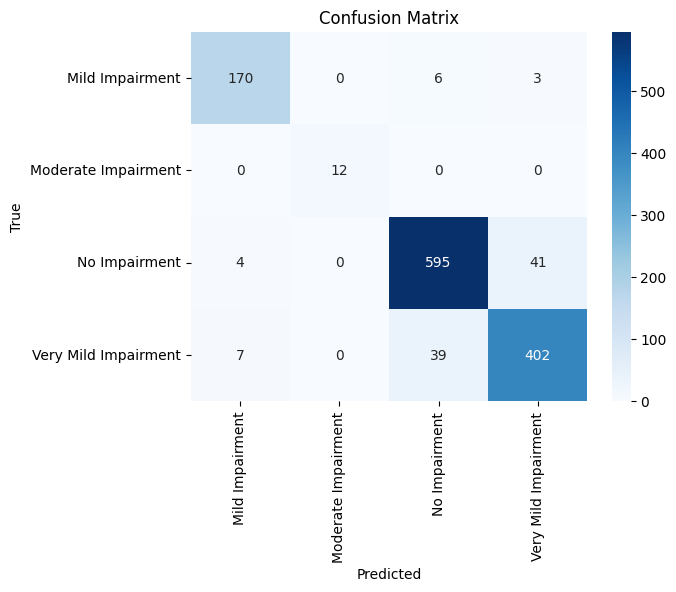

In [ ]:
# Get true and predicted labels
y_true = tf.concat([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = tf.argmax(y_pred_probs, axis=1)
y_true = tf.argmax(y_true, axis=1)

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


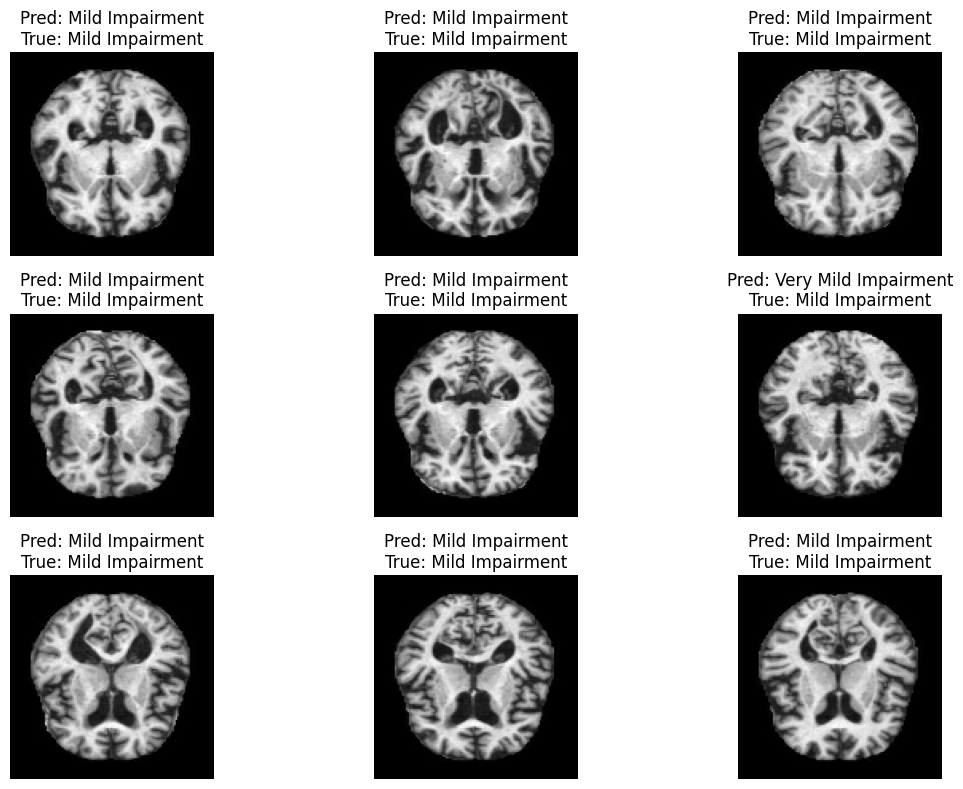

In [ ]:
for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)
    true_labels = tf.argmax(labels, axis=1)

    plt.figure(figsize=(12, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(tf.squeeze(images[i]), cmap='gray')
        pred_label = class_names[predicted_labels[i].numpy()]
        true_label = class_names[true_labels[i].numpy()]
        plt.title(f'Pred: {pred_label}\nTrue: {true_label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
